# One bid scenario

Simulating: 100%|██████████| 1000/1000 [00:00<00:00, 2992.44it/s]


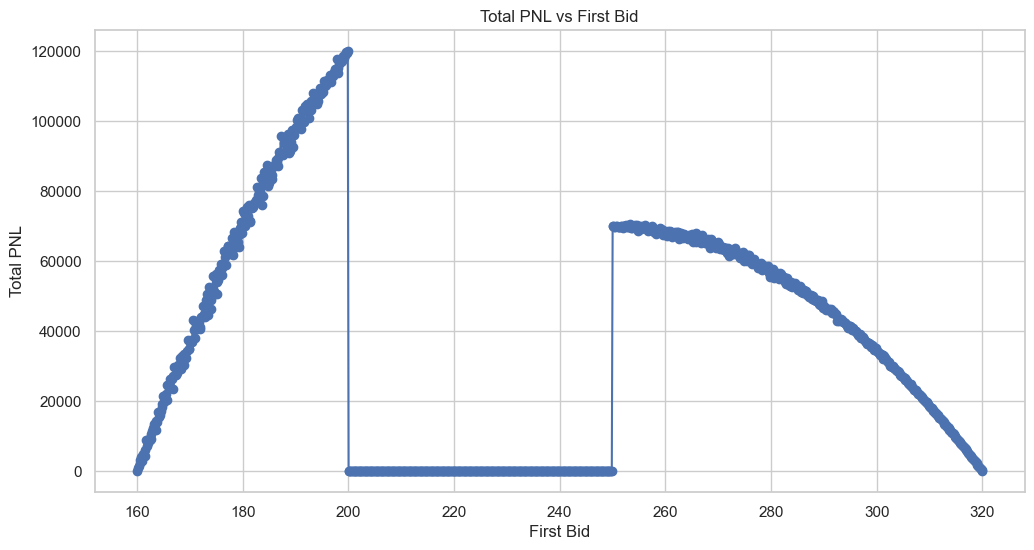

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# === Simulation Parameters ===
N_TURTLES = 2000 # ~ real will be around 2k
N_SIMULATIONS = 1000 

bids = np.linspace(160, 320, N_SIMULATIONS)


# === Reserve Price Distribution ===
def sample_reserve_prices(n):
    low = np.random.uniform(160, 200, size=n // 2)
    high = np.random.uniform(250, 320, size=n - n // 2)
    return np.concatenate([low, high])

def sample_continuous(n):
    return np.random.uniform(160, 320, size = n)

# === Monte Carlo Simulation ===
results = []

for sim in tqdm(range(N_SIMULATIONS), desc="Simulating"):
    reserve_prices = sample_reserve_prices(N_TURTLES)
    # reserve_prices = sample_continuous(N_TURTLES)
    first_bid = bids[sim]
    
    pnl = 0
    for reserve in reserve_prices:
        if first_bid >= reserve and (first_bid<200 or first_bid>250): # First bid wins
            pnl += 320 - first_bid

    results.append({
        "sim": sim,
        "first_bid": first_bid,
        "Total PNL": pnl
    })

# Graph the results
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.title("Total PNL vs First Bid")
plt.xlabel("First Bid")
plt.ylabel("Total PNL")
plt.plot(bids, [result["Total PNL"] for result in results], marker='o', linestyle='-')
plt.grid(True)
plt.show()

# Two bid scenario (no P)

Simulating: 100%|██████████| 160/160 [00:09<00:00, 16.42it/s]


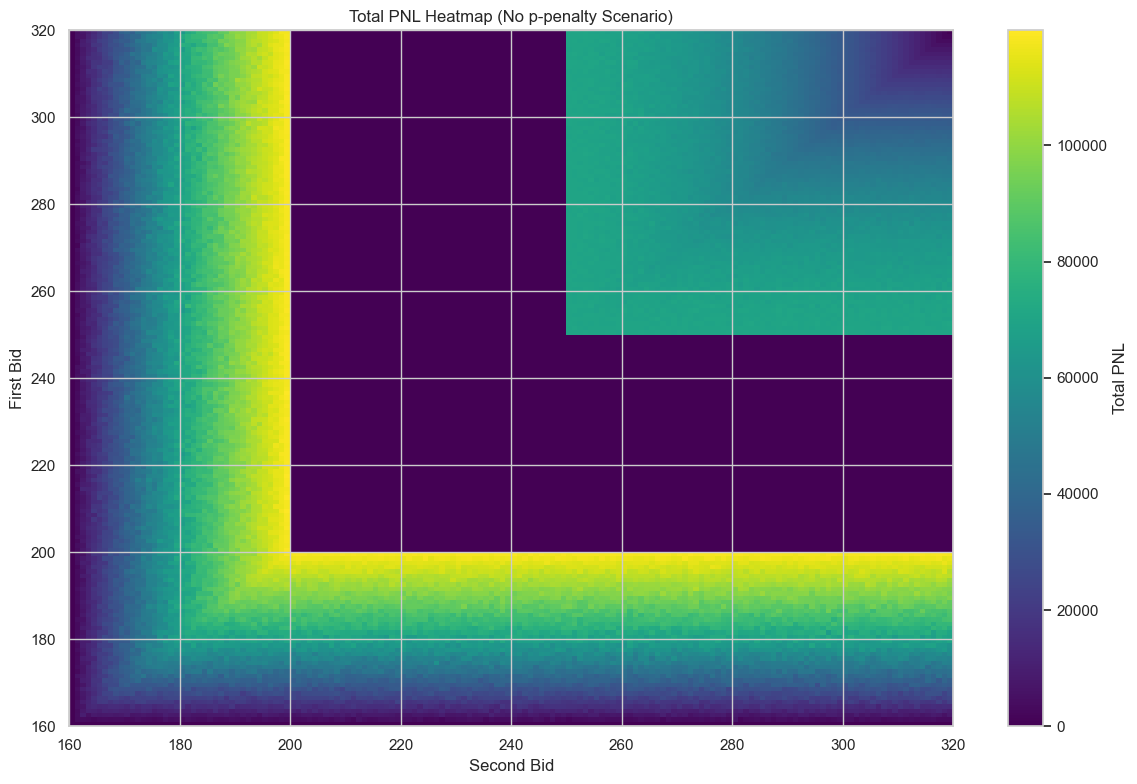

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import display

# === Simulation Parameters ===
N_TURTLES = 2000 # ~ real will be around 2k
N_SIMULATIONS = 160 # ^2 in this scenario

first_bids = np.linspace(160, 320, N_SIMULATIONS)
second_bids = np.linspace(160, 320, N_SIMULATIONS)

# === Reserve Price Distribution ===
def sample_reserve_prices(n):
    low = np.random.uniform(160, 200, size=n // 2)
    high = np.random.uniform(250, 320, size=n - n // 2)
    return np.concatenate([low, high])

# === Monte Carlo Simulation ===
results = []
for sim_1 in tqdm(range(N_SIMULATIONS), desc="Simulating"):
    for sim_2 in range(N_SIMULATIONS):
        reserve_prices = sample_reserve_prices(N_TURTLES)
        first_bid = first_bids[sim_1]
        second_bid = second_bids[sim_2]
        
        pnl = 0
        for reserve in reserve_prices:
            if first_bid >= reserve and second_bid >= first_bid: # First bid wins
                if (first_bid>200 and first_bid<250): # Turtles dont trade
                    continue    
                pnl += 320 - first_bid
                
            elif second_bid >= reserve and first_bid >= second_bid: # Second bid wins
                if (second_bid>200 and second_bid<250): # Turtles dont trade
                    continue   
                pnl += (320 - second_bid)

        results.append({
            "first_bid": first_bid,
            "second_bid": second_bid,
            "Total PNL": pnl
        })

import matplotlib.pyplot as plt

# Convert results to DataFrame
df_results_2 = pd.DataFrame(results)

# Pivot to create a grid of PNL values
pivot_df = df_results_2.pivot(index="first_bid", columns="second_bid", values="Total PNL")

# Plotting heatmap
plt.figure(figsize=(12, 8))
plt.title("Total PNL Heatmap (No p-penalty Scenario)")
plt.xlabel("Second Bid")
plt.ylabel("First Bid")
heatmap = plt.imshow(pivot_df.values, origin="lower", aspect="auto",
                     extent=[pivot_df.columns.min(), pivot_df.columns.max(),
                             pivot_df.index.min(), pivot_df.index.max()],
                     cmap="viridis")
plt.colorbar(heatmap, label="Total PNL")
plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import display

# === Simulation Parameters ===
N_TURTLES = 2000 # ~ real will be around 2k
N_SIMULATIONS = 40 # ^3 in this scenario

first_bids = np.linspace(160, 320, N_SIMULATIONS)
second_bids = np.linspace(160, 320, N_SIMULATIONS)
avg_second_bids = np.linspace(160, 320, N_SIMULATIONS)

# === Reserve Price Distribution ===
def sample_reserve_prices(n):
    low = np.random.uniform(160, 200, size=n // 2)
    high = np.random.uniform(250, 320, size=n - n // 2)
    return np.concatenate([low, high])

# === Monte Carlo Simulation ===
results = []
for sim_1 in tqdm(range(N_SIMULATIONS), desc="Simulating"):
    for sim_2 in range(N_SIMULATIONS):
        for sim_3 in range(N_SIMULATIONS):
            reserve_prices = sample_reserve_prices(N_TURTLES)
            first_bid = first_bids[sim_1]
            second_bid = second_bids[sim_2]
            avg_second_bid = avg_second_bids[sim_3]
            
            pnl = 0
            for reserve in reserve_prices:
                if first_bid >= reserve and second_bid >= first_bid: # First bid wins
                    if (first_bid>200 and first_bid<250): # Turtles dont trade
                        continue    
                    pnl += 320 - first_bid
                    
                elif second_bid >= reserve and first_bid >= second_bid: # Second bid wins
                    if (second_bid>200 and second_bid<250): # Turtles dont trade
                        continue

                if second_bid >= avg_second_bid:
                    pnl += 320 - second_bid
                else:
                    p = ((320 - avg_second_bid) / (320 - second_bid)) ** 3
                    pnl += (320 - second_bid) * p

            results.append({
                "first_bid": first_bid,
                "second_bid": second_bid,
                "avg_second_bid": avg_second_bid,
                "Total PNL": pnl
            })

# Convert results to DataFrame
df_results_2p = pd.DataFrame(results)

Simulating: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


# Slice where bid2=avgbid2

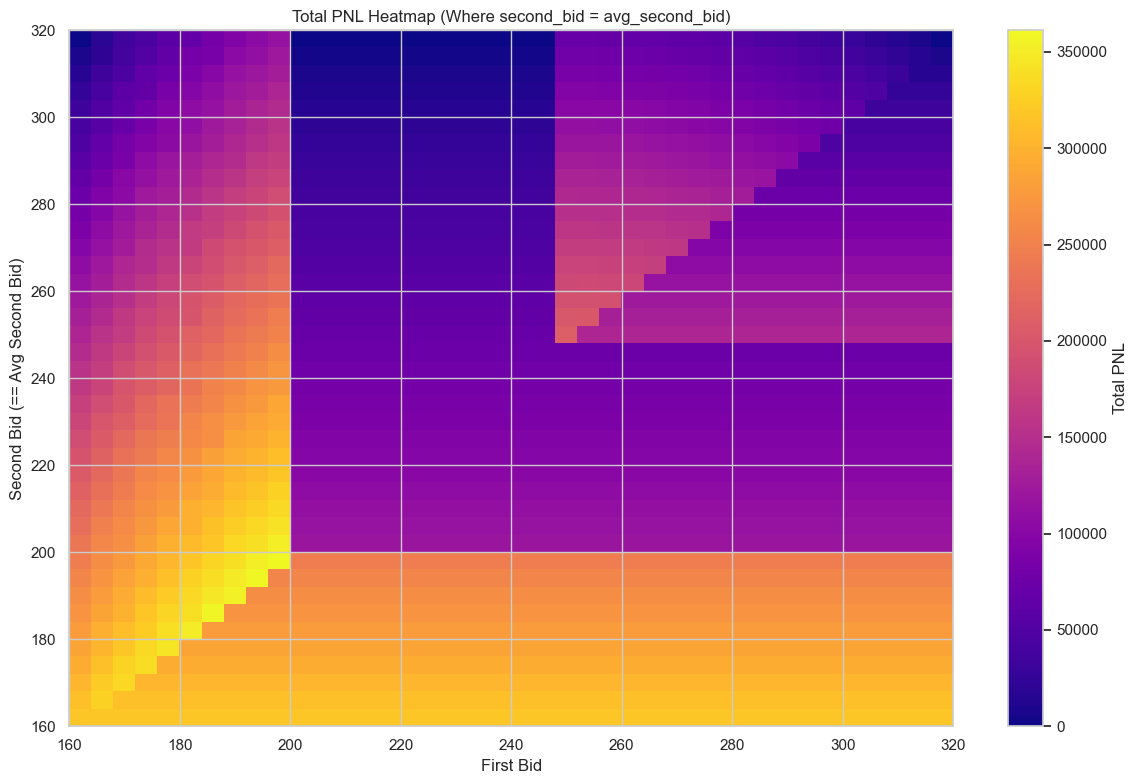

In [11]:
# Filter only where second_bid == avg_second_bid
df_filtered = df_results_2p[np.isclose(df_results_2p["second_bid"], df_results_2p["avg_second_bid"], atol=1e-2)]

# Pivot for heatmap
pivot_df = df_filtered.pivot(index="second_bid", columns="first_bid", values="Total PNL")

# Plot heatmap
plt.figure(figsize=(12, 8))
plt.title("Total PNL Heatmap (Where second_bid = avg_second_bid)")
plt.xlabel("First Bid")
plt.ylabel("Second Bid (== Avg Second Bid)")

heatmap = plt.imshow(
    pivot_df.values,
    cmap="plasma",
    aspect="auto",
    origin="lower",
    extent=[
        pivot_df.columns.min(), pivot_df.columns.max(),
        pivot_df.index.min(), pivot_df.index.max()
    ]
)

plt.colorbar(heatmap, label="Total PNL")
plt.tight_layout()
plt.show()

# Nash equilibrium

In [39]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import display

# === Simulation Parameters ===
N_TURTLES = 2000 # ~ real will be around 2k
N_SIMULATIONS = 5000 # 

avg_second_bids = [300]

# === Reserve Price Distribution ===
def sample_reserve_prices(n):
    low = np.random.uniform(160, 200, size=n // 2)
    high = np.random.uniform(250, 320, size=n - n // 2)
    return np.concatenate([low, high])

# === Monte Carlo Simulation ===
results = []
reserve_prices = sample_reserve_prices(N_TURTLES)
import random

for sim_1 in tqdm(range(N_SIMULATIONS), desc="Simulating"):
    best_combo = df_results_2p[np.isclose(df_results_2p["avg_second_bid"], np.mean(avg_second_bids), atol=3)].sort_values("Total PNL", ascending=False).iloc[0]
    if(random.random() > 0.2):
        first_bid = best_combo["first_bid"]
        second_bid = best_combo["second_bid"]
    else:
        first_bid = random.uniform(160,320)
        second_bid = random.uniform(160,320)

    avg_second_bids.append(second_bid)
    avg_second_bid = np.mean(avg_second_bids)

    pnl = 0
    for reserve in reserve_prices:
        if first_bid >= reserve and second_bid >= first_bid: # First bid wins
            if (first_bid>200 and first_bid<250): # Turtles dont trade
                continue    
            pnl += 320 - first_bid
            
        elif second_bid >= reserve and first_bid >= second_bid: # Second bid wins
            if (second_bid>200 and second_bid<250): # Turtles dont trade
                continue

        if second_bid >= avg_second_bid:
            pnl += 320 - second_bid
        else:
            p = ((320 - avg_second_bid) / (320 - second_bid)) ** 3
            pnl += (320 - second_bid) * p

    results.append({
        "n": sim_1,
        "first_bid": first_bid,
        "second_bid": second_bid,
        "avg_second_bid": avg_second_bid,
        "Total PNL": pnl
    })

print(np.mean(avg_second_bids))

# Convert results to DataFrame
df_results_2p_nash = pd.DataFrame(results)

Simulating: 100%|██████████| 5000/5000 [00:10<00:00, 457.32it/s]

246.33709388571774


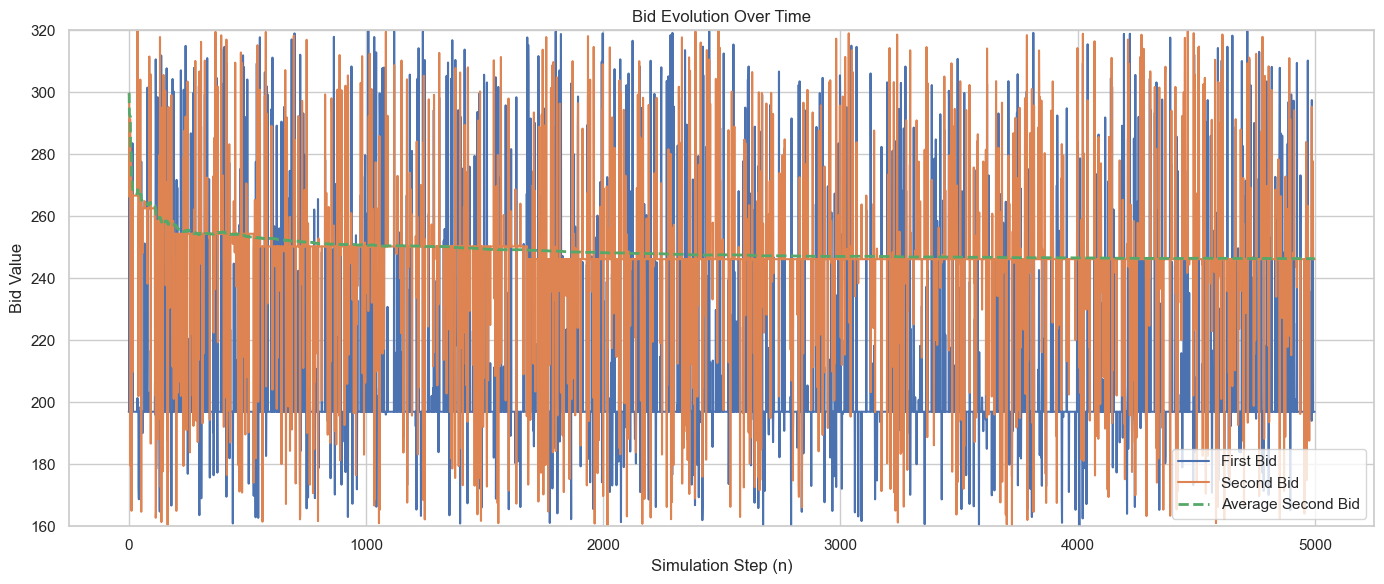

In [40]:
# Plot first_bid, second_bid, avg_second_bid over simulation steps
plt.figure(figsize=(14, 6))
plt.plot(df_results_2p_nash["n"], df_results_2p_nash["first_bid"], label="First Bid", linewidth=1.5)
plt.plot(df_results_2p_nash["n"], df_results_2p_nash["second_bid"], label="Second Bid", linewidth=1.5)
plt.plot(df_results_2p_nash["n"], df_results_2p_nash["avg_second_bid"], label="Average Second Bid", linewidth=2, linestyle="--")

plt.ylim(160, 320)
plt.xlabel("Simulation Step (n)")
plt.ylabel("Bid Value")
plt.title("Bid Evolution Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()